In [144]:
import shap
import pandas as pd
from numpy import unique, bincount
from tensorflow.random import set_seed

import pandas as pd
from numpy import unique, bincount

from tensorflow.random import set_seed

from sklearn.metrics import accuracy_score as m_accuracy_score
from sklearn.metrics import make_scorer
from imblearn.metrics import geometric_mean_score

from tensorflow.keras.losses import BinaryFocalCrossentropy
from keras import backend as K

from tensorflow import device
from tensorflow.test import gpu_device_name
device_name = gpu_device_name()
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
tf.random.set_seed(42)


from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import pickle
import torch

import eli5
from eli5.sklearn import PermutationImportance



In [12]:
with open('data/X_train.pickle', 'rb') as file:
    #X_train = pickle.load(file)
    X_train = pd.read_pickle(file)
    X_train = X_train.values
    
with open('data/y_train.pickle', 'rb') as file:
    #y_train = pickle.load(file)
    y_train = pd.read_pickle(file)
    y_train = y_train.values.ravel() 
    
with open('data/X_test.pickle', 'rb') as file:
    #y_train = pickle.load(file)
    X_test = pd.read_pickle(file)
    #X_test = X_test.values
    
with open('data/y_test.pickle', 'rb') as file:
    #y_train = pickle.load(file)
    y_test = pd.read_pickle(file)
    y_test = y_test.values.ravel()

df_preds = pd.read_csv("prediction.csv", index_col = 0)


In [13]:
def geometric_mean_metric(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    specificity = tn / (tn + fp + K.epsilon())
    sensitivity = tp / (tp + fn + K.epsilon())
    return K.sqrt(specificity * sensitivity)

# Load and train model

In [71]:
#Instantiate variables

weight_major_class, weight_minor_class = len(y_train) / (len(unique(y_train)) * bincount(y_train.ravel().astype('int64')))

# Set random state
random_state = 1
set_seed(random_state)

dropout_rate = 0.3

n_splits = 10

input_shape = X_train.shape[1]

alpha = bincount(y_train.ravel().astype('int64'))[0]/len(y_train), # inverse class weight

gamma = 1.

loss = BinaryFocalCrossentropy(alpha=alpha, gamma=gamma)

learning_rate = 0.001

#ÆNDR I FORHOLD TIL GRID
#class_weight = {0: weight_major_class, 1: weight_minor_class}
class_weight = {0: 1, 1: 1}

batch_size = 32

n_epochs = 50

# Define which metrics to show for Keras models
#metrics = {'accuracy': m_accuracy_score,
#           'g-mean': geometric_mean_score}

#refitting_metric = 'g-mean'

In [15]:
def create_cnn_model(input_shape = input_shape,
                 learning_rate = learning_rate,
                 loss=BinaryFocalCrossentropy(alpha=alpha, gamma=gamma), 
                 save_model = False, 
                 model_path = None):
    # Clear session
    K.clear_session()
    
    with device(device_name):
        inputs = Input(shape=(input_shape,1))
        layer = Conv1D(60, (3), activation='relu')(inputs)
        layer = Conv1D(60, (3), activation='relu')(inputs)
        layer = Dropout(dropout_rate)(layer)
        layer = MaxPooling1D((2))(layer)
        layer = Conv1D(30, (3), activation='relu')(layer)
        layer = Conv1D(30, (3), activation='relu')(layer)
        layer = Dropout(dropout_rate)(layer)
        #layer = MaxPooling1D((2))(layer)
        #layer = Conv1D(30, (3), activation='relu')(layer)
        #layer = Conv1D(10, (3), activation='relu')(layer)
        #layer = MaxPooling1D((2))(layer)
        layer = Flatten()(layer)
        layer = Dense(60, activation='relu')(layer)
        outputs = Dense(units=1, activation='sigmoid')(layer)

        model = Model(inputs=inputs, outputs=outputs)

        # Compile model
        model.compile(loss=loss,  
                      optimizer=Adam(learning_rate=learning_rate), 
                      metrics=['accuracy', geometric_mean_metric])

        return model

In [16]:
def train_simple_cnn_model(X, 
                   y,
                           X_val,
                           y_val,
                   input_shape, 
                   learning_rate, 
                   loss,
                    n_epochs,
                    batch_size, 
                    class_weight =  class_weight,
                   save_model=False,
                   model_path=None):    
    #Instantiate model with the best hyperparameters found in the grid search 
    cnn_model = create_cnn_model(input_shape = input_shape,
                         learning_rate = learning_rate,
                         loss=BinaryFocalCrossentropy(alpha=alpha, gamma=gamma))
    #Change to oversampled x and y 
    history = cnn_model.fit(X, y, epochs=n_epochs, batch_size=batch_size, class_weight=class_weight, validation_data = (X_val, y_val))#, callbacks=set_callbacks())#, 
    
    #print(history)
    if save_model:
        with open(model_path, 'wb') as file:
            pickle.dump(cnn_model, file)
    return history, cnn_model

In [18]:
X_train_small, X_val, y_train_small, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = random_state)

oversample = RandomOverSampler(sampling_strategy=0.5, random_state=random_state)
oversampled_X_small, oversampled_y_small = oversample.fit_resample(X_train_small, y_train_small)

history, cnn_model = train_simple_cnn_model(X =oversampled_X_small, 
                   y = oversampled_y_small, 
                      X_val = X_val,
                      y_val = y_val,
               input_shape = input_shape, 
               learning_rate = learning_rate, 
               loss = loss,
                n_epochs = n_epochs,
                batch_size = batch_size, 
                class_weight =  class_weight,
                                           save_model = True, model_path = "cnn_model_as")


Epoch 1/50
3706/3706 [==============================] - 17s 4ms/step - loss: 0.2697 - accuracy: 0.7377 - geometric_mean_metric: 0.6107 - val_loss: 0.1604 - val_accuracy: 0.8991 - val_geometric_mean_metric: 0.4228
Epoch 2/50
3706/3706 [==============================] - 16s 4ms/step - loss: 0.2513 - accuracy: 0.7676 - geometric_mean_metric: 0.6834 - val_loss: 0.1674 - val_accuracy: 0.8716 - val_geometric_mean_metric: 0.4975
Epoch 3/50
3706/3706 [==============================] - 15s 4ms/step - loss: 0.2475 - accuracy: 0.7719 - geometric_mean_metric: 0.6921 - val_loss: 0.1675 - val_accuracy: 0.8634 - val_geometric_mean_metric: 0.5197
Epoch 4/50
3706/3706 [==============================] - 15s 4ms/step - loss: 0.2456 - accuracy: 0.7744 - geometric_mean_metric: 0.6995 - val_loss: 0.1763 - val_accuracy: 0.8613 - val_geometric_mean_metric: 0.5327
Epoch 5/50
3706/3706 [==============================] - 15s 4ms/step - loss: 0.2448 - accuracy: 0.7749 - geometric_mean_metric: 0.7001 - val_loss: 0

### Load predictions

In [101]:
predictions = pd.read_csv("prediction.csv", index_col = "Unnamed: 0")
predictions  = predictions.values

# Shap

In [89]:
#Define feature names
features = ["maxspeed", "length", "lanes", 'buildings_count',
                                   'landuse_count','natural_count', 'railways_p_count',
                                    'roads_p_count', 'pofw_count', 'pois_count', 'pois_p_count',
                                'traffic_count', 'traffic_p_count', 'transport_p_count','water_count', 'waterways_p_count',
                    "distance_from_center", 'bridge', 'tunnel', 'highway_cycleway', 'highway_footway',
       'highway_other', 'highway_path', 'highway_residential',
       'highway_service', 'highway_tertiary']

In [198]:
#create random sample of points from the test set to compute the shap-values to reduce complexity
samples = shap.sample(X_test, 100, random_state = 42)

In [179]:
#Create explainer object
explainer = shap.KernelExplainer(cnn_model.predict, samples)

4/4 [==============================] - 0s 3ms/step


In [182]:
#create shap values
shap_values = explainer.shap_values(X_test[0:1000],nsamples=100)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


313/313 [==============================] - 0s 1ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


313/313 [==============================] - 0s 987us/step


In [204]:
#Create force plot
shap.force_plot(explainer.expected_value, shap_values[0], X_test,  feature_names = features)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


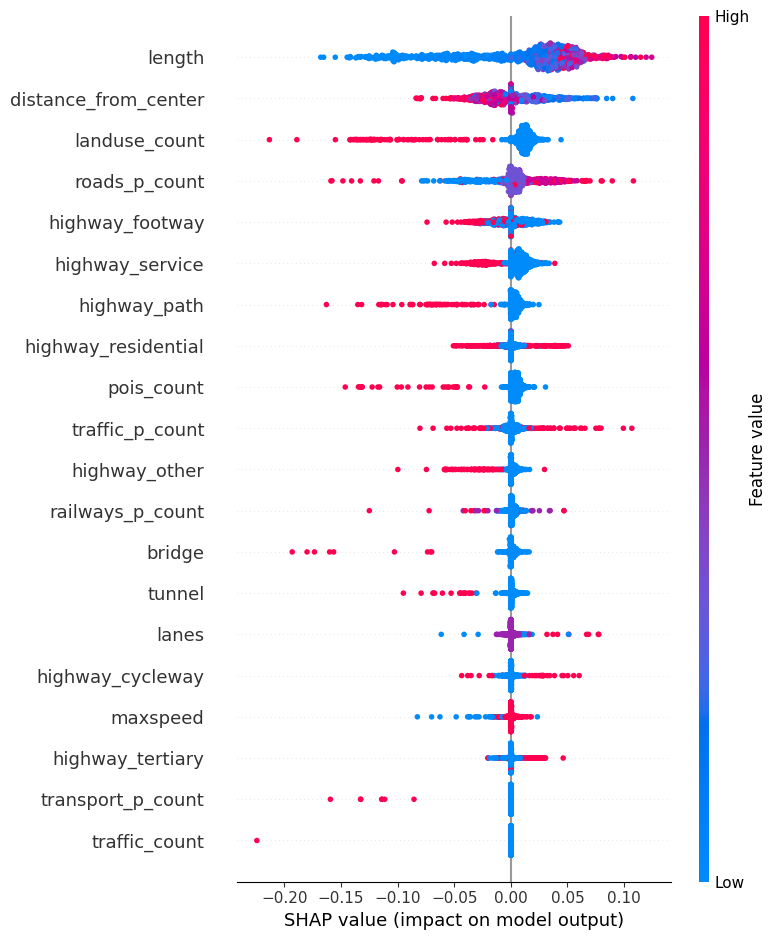

In [187]:
#Create summary plot
shap.summary_plot(shap_values[0],features= X_test[0:1000],feature_names=features)

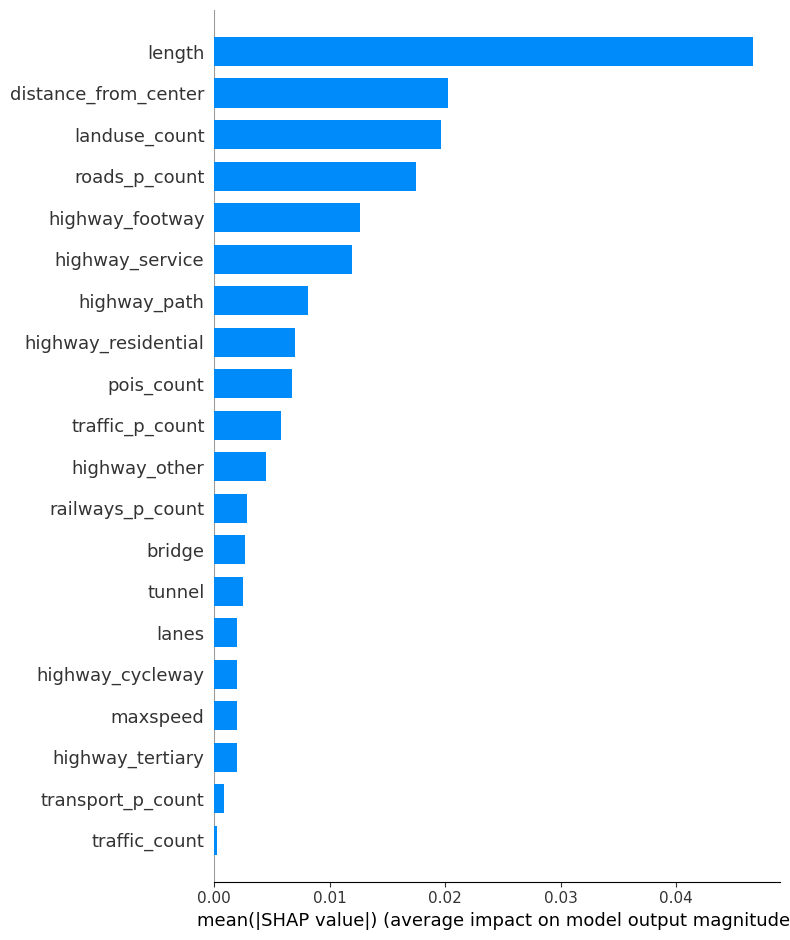

In [188]:
shap.summary_plot(shap_values[0],features=X_test,feature_names=features, plot_type = 'bar')

# Examples of force plot of single data points

In [189]:
#Force plot for index 0
shap_values0 = explainer.shap_values(X_test[0], nsamples=500)


1563/1563 [==============================] - 2s 999us/step


In [202]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values0[0], X_test[0],  feature_names = features)


In [191]:
print("Prediction: ",predictions[0])
print("Results: ",y_test[0])

Prediction:  [ True]
Results:  1.0


In [192]:
#Force plot for index 4000
shap_values4000 = explainer.shap_values(X_test[4000], nsamples=500)

1563/1563 [==============================] - 2s 1ms/step


In [200]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values4000[0], X_test[0], feature_names = features)

In [194]:
print("Prediction: ",predictions[4000])
print("Results: ",y_test[4000])

Prediction:  [False]
Results:  0.0


In [195]:
#Force plot for index 10000
shap_values10000 = explainer.shap_values(X_test[10000], nsamples=500)

1563/1563 [==============================] - 2s 1ms/step


In [203]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values10000[0], X_test[0],  feature_names = features)

In [197]:
print("Prediction: ",predictions[10000])
print("Results: ",y_test[10000])

Prediction:  [ True]
Results:  0.0


# Permutation importance

In [156]:
from scikeras.wrappers import KerasClassifier

In [165]:
model = KerasClassifier(model=cnn_model)    

In [161]:
model.fit(X_train, y_train)

2929/2929 [==============================] - 15s 5ms/step - loss: 0.0950 - accuracy: 0.9374 - geometric_mean_metric: 0.0576


AttributeError: 'str' object has no attribute '__name__'

In [166]:
perm = PermutationImportance(model, random_state=random_state).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = columns)

AttributeError: 'KerasClassifier' object has no attribute 'y_dtype_'